# Messing with vmad

In [1]:
from vmad import Builder
from vmad import autooperator
from vmad import operator
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Practice defining simple operators
@operator
class divide:
    #define inputs to operate on
    ain = 'x1', 'x2'
    #define the output to calculate
    aout = 'y'
    
    #Make a function that applys the intended operation
    def apl(ctx, x1,x2):
        return dict(y=x1/x2)
    
    #define the expression for the vector-jacobian product
    def vjp(ctx, x1, x2,_y):
        #This returns a VECTOR 
        return dict(_x1 = _y/x2, _x2=-_y*x1/x2**2  )
    
    #define the expression for the jacobian vector product
    def jvp(ctx, x1_, x2_, x1, x2):
        #This returns a SCALAR
        return dict(y_ = x1_/x2-x2_*x1/x2**2)
@operator
class mag:
    ain = 'x1', 'x2', 'x3'
    aout = 'y'
    
    def apl(ctx, x1, x2,x3):
        return dict(y=np.sqrt(x1**2+x2**2+x3**2))
    def vjp(ctx, x1, x2,x3, _y):
        return dict(_x1 = _y*x1/np.sqrt(x1**2+x2**2+x3**2), _x2=_y*x2/np.sqrt(x1**2+x2**2+x3**2), _x3=_y*x3/np.sqrt(x1**2+x2**2+x3**2))
    def jvp(ctx, x1, x2, x3,x1_, x2_, x3_):
        return dict(y_ = x1_*x1/np.sqrt(x1**2+x2**2+x3**2)+x2_*x2/np.sqrt(x1**2+x2**2+x3**2)+x3_*x3/np.sqrt(x1**2+x2**2+x3**2)) 
@operator
class add:
    ain = 'x1','x2'
    aout = 'y'
    
    def apl(ctx, x1,x2):
        return dict(y=x1+x2)
    def vjp(ctx,_y):
        return dict(_x1=_y,_x2=_y)
    def jvp(ctx, x1_,x2_):
        return dict(y_ = x1_+x2_)
@operator
class sin:
    ain = 'x1'
    aout = 'y'
    
    def apl(ctx, x1):
        return dict(y = np.sin(x1))
    def vjp(ctx, x1, _y):
        return dict(_x1 = _y*np.cos(x1))
    def jvp(ctx, x1, x1_):
        return dict(y_ = x1_*np.cos(x1))
@operator
class cos:
    ain = 'x1'
    aout = 'y'
    
    def apl(ctx, x1):
        return dict(y = np.cos(x1))
    def vjp(ctx, x1, _y):
        return dict(_x1 = -_y*np.sin(x1))
    def jvp(ctx, x1, x1_):
        return dict(y_ = -x1_*np.sin(x1))
@operator
class multiply:
    ain = 'x1', 'x2'
    aout = 'y'
    
    def apl(ctx, x1,x2):
        return dict(y=x1*x2)
    def vjp(ctx, x1,x2,_y):
        return dict(_x1 = _y*x2, _x2 = _y*x1)
    def jvp(ctx, x1, x2, x1_, x2_):
        return dict(y_ = x1_*x2+x2_*x1)


In [3]:
#Making some autooperator models

#Auto operator in class format
@autooperator
class divide_model:
    ain = {'a' : '*',
           'b' : '*'}
    aout = {'c' : '*'}

    def main(model, a, b):
        t1 = divide(a, b)
        t2 = divide(b, a)
        return dict(c=divide(t1, t2))

#Auto operator in function format 
@autooperator('a,b->c')
def trig_model(a,b):
    t1 = multiply(sin(a), cos(b))
    t2 = multiply(sin(a),sin(b))
    return dict(c= multiply(t2,t1))
    

@autooperator('a,b->c')
def sin_model(a,b):
    t1 = sin(a)
    return dict(c= t1)

@autooperator('a,b->c')
def square_model(a,b):
    #Computes the fourier series for a triangle wave
    t1 = sin(a*np.pi/2.5)
    for i in range(3,100,2):
        t1 += multiply(1/i,sin(i*a*np.pi/2.5))
    return dict(c= 4/np.pi*t1)

@autooperator('a,b->c')
def triangle_model(a,b):
    t1 = sin(a*np.pi/2.5)
    for i in range(3,100,2):
        t1 += (-1)**((i-1)/2)* multiply(1/i**2,sin(i*a*np.pi/2.5))
    return dict(c= 8/np.pi**2*t1)


In [4]:
#Run function to save copy and pasting
def run(model_name, init, vjp_init, jvp_init):
    m = model_name.build()
    c,tape = m.compute(init=init, vout='c', return_tape=True)
    vjp = tape.get_vjp()
    _a,_b = vjp.compute(init=vjp_init, vout=['_a', '_b'])
    jvp=tape.get_jvp()
    c_, = jvp.compute(init=jvp_init, vout=['c_'])
    return dict(c=c, _a=_a, _b=_b, c_=c_)

In [5]:
#Running the models
init = dict(a=3, b=4)
vjp_init = dict(_c=1.0)
jvp_init = dict(a_=1.0, b_=1.0)

divide_results = run(divide_model, init, vjp_init, jvp_init)

init = dict(a=np.linspace(.001,2*np.pi,1000), b=np.linspace(.001,2*np.pi,1000))
trig_results = run(trig_model, init, vjp_init, jvp_init)
sin_results = run(sin_model, init, vjp_init, jvp_init)

init = dict(a = np.linspace(.001,5,1000), b = np.linspace(.001,5,1000))

sqr_results = run(square_model, init, vjp_init, jvp_init)
tri_results = run(triangle_model, init, vjp_init, jvp_init)

In [6]:
#as a check for the divide model
print('--------Manually computed--------')
print('c= ',3/4/(4/3) ,'_a= ', 2*3/16,'_b= ' ,-3**2*2/4**3,'c_ = ', 2*3/16-3**2*2/4**3, '\n')

print('---------Model computed-----------')
print(divide_results)

--------Manually computed--------
c=  0.5625 _a=  0.375 _b=  -0.28125 c_ =  0.09375 

---------Model computed-----------
{'c': 0.5625, '_a': 0.375, '_b': -0.28125, 'c_': 0.09375}


In [7]:
%matplotlib notebook

<IPython.core.display.Javascript object>


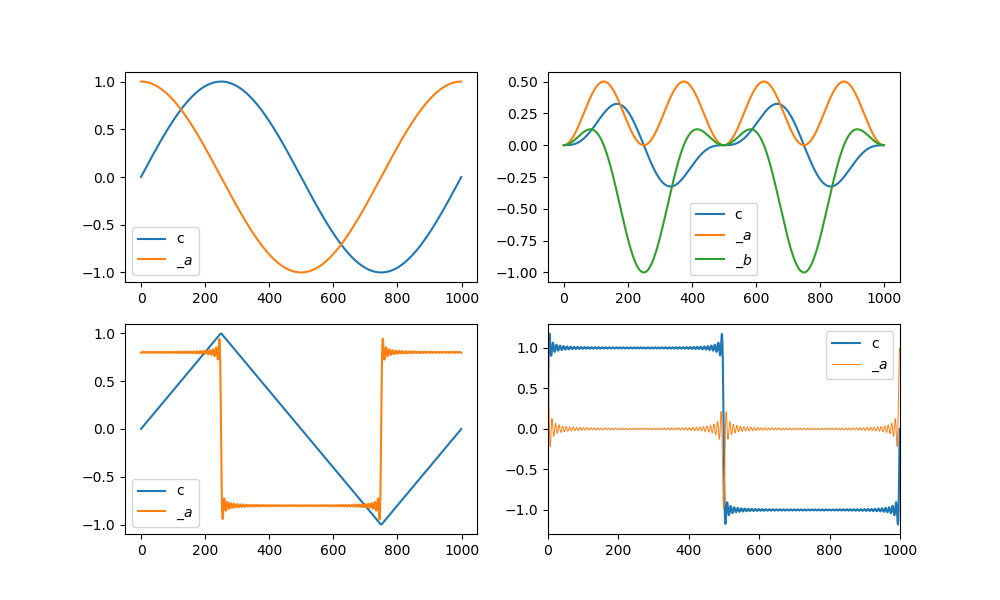

In [8]:
#Plots
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(sin_results['c'], label='c')
plt.plot(sin_results['_a'], label='$\_a$')
plt.legend()
plt.subplot(222)
plt.plot(trig_results['c'], label='c')
plt.plot(trig_results['_a'], label='$\_a$')
plt.plot(trig_results['_b'], label='$\_b$')
plt.legend()
plt.subplot(223)
plt.plot(tri_results['c'], label='c')
plt.plot(tri_results['_a'], label='$\_a$')
plt.legend()
plt.subplot(224)
plt.plot(sqr_results['c'], label='c')
plt.plot(sqr_results['_a']/sqr_results['_a'].max(), label='$\_a$', lw=.7)
plt.xlim(0,1000)
plt.legend()